## Data Dictionary

Below is a detailed description of each feature in both tables included in the Credit Card Approval Prediction dataset:

### application_record.csv

| Feature Name         | Explanation                | Remarks                                                                                           |
|----------------------|---------------------------|---------------------------------------------------------------------------------------------------|
| ID                   | Client number             | Unique identifier for each client                                                                  |
| CODE_GENDER          | Gender                    | Values: M (male), F (female)                                                                      |
| FLAG_OWN_CAR         | Is there a car            | 1 if the client owns a car, 0 otherwise                                                           |
| FLAG_OWN_REALTY      | Is there a property       | 1 if the client owns property, 0 otherwise                                                        |
| CNT_CHILDREN         | Number of children        | Number of children the client has                                                                  |
| AMT_INCOME_TOTAL     | Annual income             | Client's annual income                                                                            |
| NAME_INCOME_TYPE     | Income category           | Type of income: e.g., Working, Commercial associate, Pensioner, State servant, Unemployed         |
| NAME_EDUCATION_TYPE  | Education level           | Level of education: e.g., Higher education, Secondary, Academic degree, Lower secondary           |
| NAME_FAMILY_STATUS   | Marital status            | Client's family status: e.g., Single, Married, Civil marriage, Separated, Widow                   |
| NAME_HOUSING_TYPE    | Way of living             | Type of housing: e.g., Own house/apartment, With parents, Municipal, Co-op, Rented, Office apt    |
| DAYS_BIRTH           | Birthday                  | Counted backwards from current day (0); negative values, -1 means yesterday                       |
| DAYS_EMPLOYED        | Start date of employment  | Counted backwards from current day (0). If positive, client is currently unemployed               |
| FLAG_MOBIL           | Is there a mobile phone   | 1 if the client has a mobile phone, 0 otherwise                                                   |
| FLAG_WORK_PHONE      | Is there a work phone     | 1 if the client has a work phone, 0 otherwise                                                     |
| FLAG_PHONE           | Is there a phone          | 1 if the client has a phone, 0 otherwise                                                          |
| FLAG_EMAIL           | Is there an email         | 1 if the client has an email address, 0 otherwise                                                 |
| OCCUPATION_TYPE      | Occupation                | Client's occupation                                                                               |
| CNT_FAM_MEMBERS      | Family size               | Number of family members                                                                          |

### credit_record.csv

| Feature Name    | Explanation              | Remarks                                                                                                                                                                                      |
|-----------------|-------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ID              | Client number           | Unique identifier for each client                                                                                                                      |
| MONTHS_BALANCE  | Record month            | The month of the extracted data is the starting point; 0 is the current month, -1 is the previous month, and so on                                    |
| STATUS          | Status                  | Payment status: <br>0 = 1–29 days past due <br>1 = 30–59 days past due <br>2 = 60–89 days overdue <br>3 = 90–119 days overdue <br>4 = 120–149 days overdue <br>5 = Overdue or bad debts, write-offs for more than 150 days <br>C = Paid off that month <br>X = No loan for the month |

---

This data dictionary provides clarity on the attributes available for modeling and feature engineering in the credit approval prediction task.


In [0]:
%pip install xgboost lightgbm catboost  --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
%pip install pycaret --quiet

Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


In [0]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import pandas as pd   
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

import pycaret
from pycaret.classification import *

In [0]:
record = pd.read_csv("Data/credit_record.csv")
display(record.head())

ID,MONTHS_BALANCE,STATUS
5001711,0,X
5001711,-1,0
5001711,-2,0
5001711,-3,0
5001712,0,C


In [0]:
data = pd.read_csv("Data/application_record.csv")
data.head()

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


In [0]:
record.isnull().sum()

ID                0
MONTHS_BALANCE    0
STATUS            0
dtype: int64

In [0]:
for col in record.columns:
    print(f"\n Column: {col}")
    print(record[col].unique())


 Column: ID
[5001711 5001712 5001713 ... 5150484 5150485 5150487]

 Column: MONTHS_BALANCE
[  0  -1  -2  -3  -4  -5  -6  -7  -8  -9 -10 -11 -12 -13 -14 -15 -16 -17
 -18 -19 -20 -21 -22 -23 -24 -25 -26 -27 -28 -29 -30 -31 -32 -33 -34 -35
 -36 -37 -38 -39 -40 -41 -42 -43 -44 -45 -46 -47 -48 -49 -50 -51 -52 -53
 -54 -55 -56 -57 -58 -59 -60]

 Column: STATUS
['X' '0' 'C' '1' '2' '3' '4' '5']


### credit_record.csv

| Feature Name    | Explanation              | Remarks                                                                                                                                                                                      |
|-----------------|-------------------------|----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ID              | Client number           | Unique identifier for each client                                                                                                                      |
| MONTHS_BALANCE  | Record month            | The month of the extracted data is the starting point; 0 is the current month, -1 is the previous month, and so on                                    |
| STATUS          | Status                  | Payment status: <br>0 = 1–29 days past due <br>1 = 30–59 days past due <br>2 = 60–89 days overdue <br>3 = 90–119 days overdue <br>4 = 120–149 days overdue <br>5 = Overdue or bad debts, write-offs for more than 150 days <br>C = Paid off that month <br>X = No loan for the month |

---

#Pre-Processing

In [0]:
begin_month = (
    record.groupby("ID")['MONTHS_BALANCE']
    .min()
    .rename("begin_month")
    .to_frame()
)
begin_month.head()

,begin_month
ID,
5001711,-3
5001712,-18
5001713,-21
5001714,-14
5001715,-59


In [0]:

record['dep_value'] = None
record.loc[record['STATUS'].isin(['2', '3', '4', '5']), 'dep_value'] = 'Yes'

cpunt = record.groupby('ID')['dep_value'].apply(lambda x: 'Yes' if (x == 'Yes').any() else 'No')
cpunt = cpunt.to_frame()


In [0]:
print(cpunt['dep_value'].value_counts())
cpunt['dep_value'].value_counts(normalize=True)

No     45318
Yes      667
Name: dep_value, dtype: int64


No     0.985495
Yes    0.014505
Name: dep_value, dtype: float64

In [0]:
data = pd.merge(data, begin_month, how = "left", on = "ID")
data = pd.merge(data, cpunt, how = "inner", on = "ID" )
data['label'] = data['dep_value'].map({'Yes': 1, 'No': 0})
display(data.head())

ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,begin_month,dep_value,label
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,null,2.0,-15.0,No,0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,null,2.0,-14.0,No,0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0,-29.0,No,0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-4.0,No,0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0,-26.0,No,0


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 21 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   36457 non-null  int64  
 1   CODE_GENDER          36457 non-null  object 
 2   FLAG_OWN_CAR         36457 non-null  object 
 3   FLAG_OWN_REALTY      36457 non-null  object 
 4   CNT_CHILDREN         36457 non-null  int64  
 5   AMT_INCOME_TOTAL     36457 non-null  float64
 6   NAME_INCOME_TYPE     36457 non-null  object 
 7   NAME_EDUCATION_TYPE  36457 non-null  object 
 8   NAME_FAMILY_STATUS   36457 non-null  object 
 9   NAME_HOUSING_TYPE    36457 non-null  object 
 10  DAYS_BIRTH           36457 non-null  int64  
 11  DAYS_EMPLOYED        36457 non-null  int64  
 12  FLAG_MOBIL           36457 non-null  int64  
 13  FLAG_WORK_PHONE      36457 non-null  int64  
 14  FLAG_PHONE           36457 non-null  int64  
 15  FLAG_EMAIL           36457 non-null 

In [0]:
data = data.rename(columns={'CODE_GENDER':'Gender','FLAG_OWN_CAR':'Car','FLAG_OWN_REALTY':'Reality',
                         'CNT_CHILDREN':'ChldNo','AMT_INCOME_TOTAL':'inc',
                         'NAME_EDUCATION_TYPE':'edutp','NAME_FAMILY_STATUS':'famtp',
                        'NAME_HOUSING_TYPE':'houtp','FLAG_EMAIL':'email',
                         'NAME_INCOME_TYPE':'inctp','FLAG_WORK_PHONE':'wkphone',
                         'FLAG_PHONE':'phone','CNT_FAM_MEMBERS':'famsize',
                        'OCCUPATION_TYPE':'occyp'
                        })

In [0]:
data.isnull().sum()

ID                   0
Gender               0
Car                  0
Reality              0
ChldNo               0
inc                  0
inctp                0
edutp                0
famtp                0
houtp                0
DAYS_BIRTH           0
DAYS_EMPLOYED        0
FLAG_MOBIL           0
wkphone              0
phone                0
email                0
occyp            11323
famsize              0
begin_month          0
dep_value            0
label                0
dtype: int64

Dont forget Change days_employed

In [0]:
data = data.drop(columns = ['dep_value', 'email', 'phone', 'wkphone', 'FLAG_MOBIL'])

In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   ID             36457 non-null  int64  
 1   Gender         36457 non-null  object 
 2   Car            36457 non-null  object 
 3   Reality        36457 non-null  object 
 4   ChldNo         36457 non-null  int64  
 5   inc            36457 non-null  float64
 6   inctp          36457 non-null  object 
 7   edutp          36457 non-null  object 
 8   famtp          36457 non-null  object 
 9   houtp          36457 non-null  object 
 10  DAYS_BIRTH     36457 non-null  int64  
 11  DAYS_EMPLOYED  36457 non-null  int64  
 12  occyp          25134 non-null  object 
 13  famsize        36457 non-null  float64
 14  begin_month    36457 non-null  float64
 15  label          36457 non-null  int64  
dtypes: float64(3), int64(5), object(8)
memory usage: 4.7+ MB


In [0]:
display(data.head()) 

ID,Gender,Car,Reality,ChldNo,inc,inctp,edutp,famtp,houtp,DAYS_BIRTH,DAYS_EMPLOYED,occyp,famsize,begin_month,label
5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,null,2.0,-15.0,0
5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,null,2.0,-14.0,0
5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,Security staff,2.0,-29.0,0
5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1.0,-4.0,0
5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,Sales staff,1.0,-26.0,0


In [0]:
data['occyp'] = data['occyp'].fillna('Unknown')
print("\n Gender :", data['Gender'].unique())
print("\n Car :", data['Car'].unique())
print("\n Reality :", data['Reality'].unique())
print("\n ChldNo :", data['ChldNo'].unique())
print("\n inctp :", data['inctp'].unique())
print("\n edutp :", data['edutp'].unique())
print("\n famtp :", data['famtp'].unique())
print("\n houtp :", data['houtp'].unique())
print("\n occyp :", data['occyp'].unique())


 Gender : ['M' 'F']

 Car : ['Y' 'N']

 Reality : ['Y' 'N']

 ChldNo : [ 0  1  3  2  4  5 14 19  7]

 inctp : ['Working' 'Commercial associate' 'Pensioner' 'State servant' 'Student']

 edutp : ['Higher education' 'Secondary / secondary special' 'Incomplete higher'
 'Lower secondary' 'Academic degree']

 famtp : ['Civil marriage' 'Married' 'Single / not married' 'Separated' 'Widow']

 houtp : ['Rented apartment' 'House / apartment' 'Municipal apartment'
 'With parents' 'Co-op apartment' 'Office apartment']

 occyp : ['Unknown' 'Security staff' 'Sales staff' 'Accountants' 'Laborers'
 'Managers' 'Drivers' 'Core staff' 'High skill tech staff'
 'Cleaning staff' 'Private service staff' 'Cooking staff'
 'Low-skill Laborers' 'Medicine staff' 'Secretaries'
 'Waiters/barmen staff' 'HR staff' 'Realty agents' 'IT staff']


In [0]:


data['Gender'] = data['Gender'].map({'F': 0, 'M': 1})
data['Car'] = data['Car'].map({'N': 0, 'Y': 1})
data['Reality'] = data['Reality'].map({'N': 0, 'Y': 1})

data = pd.get_dummies(data, columns = ['inctp', 'edutp', 'famtp', 'houtp', 'occyp'], dtype='int32')


In [0]:
for col in ['Gender', 'Car', 'Reality']:
    data[col] = data[col].astype('int32')


In [0]:
display(data.head())

ID,Gender,Car,Reality,ChldNo,inc,DAYS_BIRTH,DAYS_EMPLOYED,famsize,begin_month,label,inctp_Commercial associate,inctp_Pensioner,inctp_State servant,inctp_Student,inctp_Working,edutp_Academic degree,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,edutp_Secondary / secondary special,famtp_Civil marriage,famtp_Married,famtp_Separated,famtp_Single / not married,famtp_Widow,houtp_Co-op apartment,houtp_House / apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,occyp_Accountants,occyp_Cleaning staff,occyp_Cooking staff,occyp_Core staff,occyp_Drivers,occyp_HR staff,occyp_High skill tech staff,occyp_IT staff,occyp_Laborers,occyp_Low-skill Laborers,occyp_Managers,occyp_Medicine staff,occyp_Private service staff,occyp_Realty agents,occyp_Sales staff,occyp_Secretaries,occyp_Security staff,occyp_Unknown,occyp_Waiters/barmen staff
5008804,1,1,1,0,427500.0,-12005,-4542,2.0,-15.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5008805,1,1,1,0,427500.0,-12005,-4542,2.0,-14.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
5008806,1,1,1,0,112500.0,-21474,-1134,2.0,-29.0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
5008808,0,0,1,0,270000.0,-19110,-3051,1.0,-4.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
5008809,0,0,1,0,270000.0,-19110,-3051,1.0,-26.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [0]:
data['EMPLOYED_FLAG'] = (data['DAYS_EMPLOYED'] != 365243).astype(int)

In [0]:
data['AGE_YEARS'] = (-data['DAYS_BIRTH']) // 365
data['YEARS_EMPLOYED'] = np.where(data['DAYS_EMPLOYED'] == 365243, 0, -data['DAYS_EMPLOYED'] // 365)
data = data.drop(columns = ['DAYS_BIRTH', 'DAYS_EMPLOYED'])

print("\n YEARS_EMPLOYED: ", data['YEARS_EMPLOYED'].unique())


 YEARS_EMPLOYED:  [12  3  8  0  2  4  5 19 14 13  7  6 17 29  1 15 11 10 23 24 20  9 27 26
 18 21 22 16 28 38 32 31 36 37 30 39 25 34 33 41 40 35 43 42]


In [0]:
display(data.head())

ID,Gender,Car,Reality,ChldNo,inc,famsize,begin_month,label,inctp_Commercial associate,inctp_Pensioner,inctp_State servant,inctp_Student,inctp_Working,edutp_Academic degree,edutp_Higher education,edutp_Incomplete higher,edutp_Lower secondary,edutp_Secondary / secondary special,famtp_Civil marriage,famtp_Married,famtp_Separated,famtp_Single / not married,famtp_Widow,houtp_Co-op apartment,houtp_House / apartment,houtp_Municipal apartment,houtp_Office apartment,houtp_Rented apartment,houtp_With parents,occyp_Accountants,occyp_Cleaning staff,occyp_Cooking staff,occyp_Core staff,occyp_Drivers,occyp_HR staff,occyp_High skill tech staff,occyp_IT staff,occyp_Laborers,occyp_Low-skill Laborers,occyp_Managers,occyp_Medicine staff,occyp_Private service staff,occyp_Realty agents,occyp_Sales staff,occyp_Secretaries,occyp_Security staff,occyp_Unknown,occyp_Waiters/barmen staff,EMPLOYED_FLAG,AGE_YEARS,YEARS_EMPLOYED
5008804,1,1,1,0,427500.0,2.0,-15.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,32,12
5008805,1,1,1,0,427500.0,2.0,-14.0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,32,12
5008806,1,1,1,0,112500.0,2.0,-29.0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,58,3
5008808,0,0,1,0,270000.0,1.0,-4.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,52,8
5008809,0,0,1,0,270000.0,1.0,-26.0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,52,8


In [0]:
print(data['label'].unique()) # Good Debt Bad Debt

[0 1]


In [0]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36457 entries, 0 to 36456
Data columns (total 52 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   ID                                   36457 non-null  int64  
 1   Gender                               36457 non-null  int32  
 2   Car                                  36457 non-null  int32  
 3   Reality                              36457 non-null  int32  
 4   ChldNo                               36457 non-null  int64  
 5   inc                                  36457 non-null  float64
 6   famsize                              36457 non-null  float64
 7   begin_month                          36457 non-null  float64
 8   label                                36457 non-null  int64  
 9   inctp_Commercial associate           36457 non-null  int32  
 10  inctp_Pensioner                      36457 non-null  int32  
 11  inctp_State servant         

#Model

In [0]:
stp = setup(
    data = data,
    target= 'label',
    train_size=0.8,
    ignore_features=['ID'],
    fix_imbalance=True,
    session_id=123
)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0xff2ff062af20>
Traceback (most recent call last):
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/databricks/python/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 'split'
Ex

,Description,Value
0,Session id,123
1,Target,label
2,Target type,Binary
3,Original data shape,"(36457, 52)"
4,Transformed data shape,"(64636, 51)"
5,Transformed train set shape,"(57344, 51)"
6,Transformed test set shape,"(7292, 51)"
7,Ignore features,1
8,Numeric features,50
9,Preprocess,True


In [0]:
est_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.9831,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.078
catboost,CatBoost Classifier,0.9827,0.7585,0.1501,0.4590,0.2246,0.2182,0.2544,30.324
xgboost,Extreme Gradient Boosting,0.9824,0.7458,0.1359,0.4411,0.2059,0.1996,0.2365,0.830
lightgbm,Light Gradient Boosting Machine,0.9822,0.7379,0.1135,0.4138,0.1769,0.1708,0.2089,3.189
rf,Random Forest Classifier,0.9819,0.7676,0.1784,0.4069,0.2459,0.2383,0.2602,3.781
gbc,Gradient Boosting Classifier,0.9813,0.6523,0.0142,0.1283,0.0249,0.0210,0.0351,10.005
et,Extra Trees Classifier,0.9805,0.7267,0.2212,0.3702,0.2750,0.2658,0.2758,4.281
ada,Ada Boost Classifier,0.9766,0.6172,0.0061,0.0125,0.0080,-0.0011,-0.0016,1.969
dt,Decision Tree Classifier,0.9712,0.6071,0.2192,0.1876,0.2013,0.1868,0.1878,0.267
knn,K Neighbors Classifier,0.8386,0.6315,0.3777,0.0405,0.0731,0.0440,0.0792,1.536


# Model Evaluation Summary

Several classification models were tested to predict the target variable. The main metrics used to compare models were Accuracy, AUC (Area Under the ROC Curve), Recall, Precision, F1-Score, Kappa, and MCC (Matthews Correlation Coefficient).

- **Accuracy:** Measures the overall percentage of correct predictions but can be misleading if the data is imbalanced.
- **AUC:** Reflects the model’s ability to distinguish between classes; values closer to 1 are better.
- **Recall:** Indicates how well the model detects positive cases.
- **Precision:** Measures how many predicted positives are actually correct.
- **F1-Score:** Balances Precision and Recall into a single metric.
- **Kappa and MCC:** Assess the model's performance accounting for chance agreement and class imbalance.

The best performing model for this dataset was **CatBoost Classifier**, showing the highest balance between Recall, Precision, and overall discrimination (AUC). Random Forest and Extra Trees classifiers also performed well.

Models with high accuracy but low recall or precision (like the Dummy classifier) are not reliable because they tend to predict only the majority class.


In [0]:
catboost_model = create_model('catboost')

catboost_model = finalize_model(catboost_model)

print(catboost_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.9832,0.8019,0.1020,0.5000,0.1695,0.1647,0.2205
1,0.9825,0.7472,0.1837,0.4500,0.2609,0.2536,0.2801
2,0.9839,0.7528,0.2000,0.5882,0.2985,0.2924,0.3369
3,0.9822,0.7808,0.1400,0.4375,0.2121,0.2055,0.2405
4,0.9825,0.6810,0.1200,0.4615,0.1905,0.1847,0.2291
5,0.9818,0.7849,0.1429,0.3889,0.2090,0.2017,0.2281
6,0.9818,0.6889,0.1429,0.3889,0.2090,0.2017,0.2281
7,0.9842,0.8078,0.2245,0.5789,0.3235,0.3171,0.3542
8,0.9822,0.7258,0.1020,0.3846,0.1613,0.1553,0.1915


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['Gender', 'Car', 'Reality',
                                             'ChldNo', 'inc', 'famsize',
                                             'begin_month',
                                             'inctp_Commercial associate',
                                             'inctp_Pensioner',
                                             'inctp_State servant',
                                             'inctp_Student', 'inctp_Working',
                                             'edutp_Academic degree',
                                             'edutp_Higher education',
                                             'edutp_Incomplete higher',
                                             'edutp_L...
                 TransformerWrapper(exclude=None, include=None,
                                    transformer

In [0]:
evaluate_model(catboost_model)

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

''

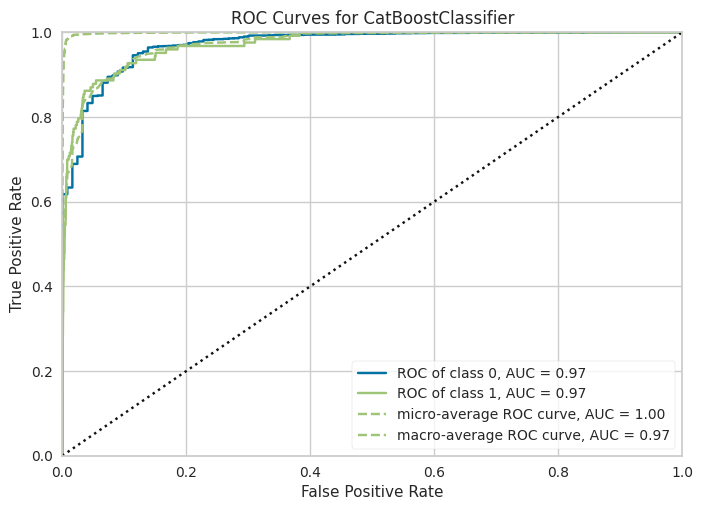

In [0]:
plot_model(catboost_model, plot = 'auc')

''

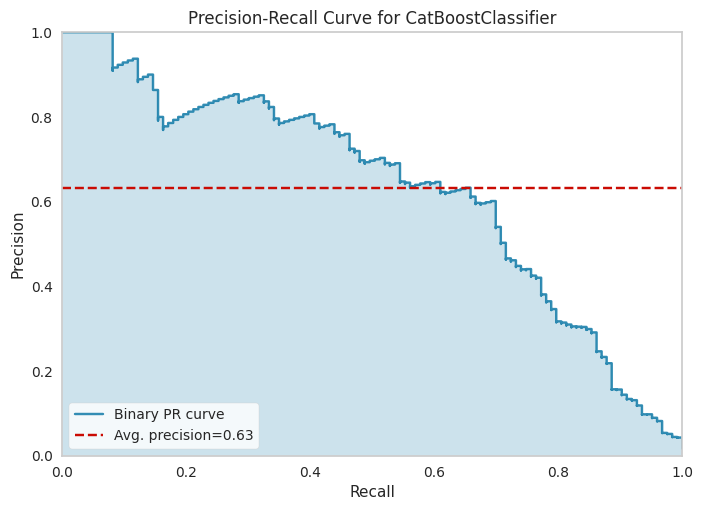

In [0]:
plot_model(catboost_model, plot = 'pr')

''

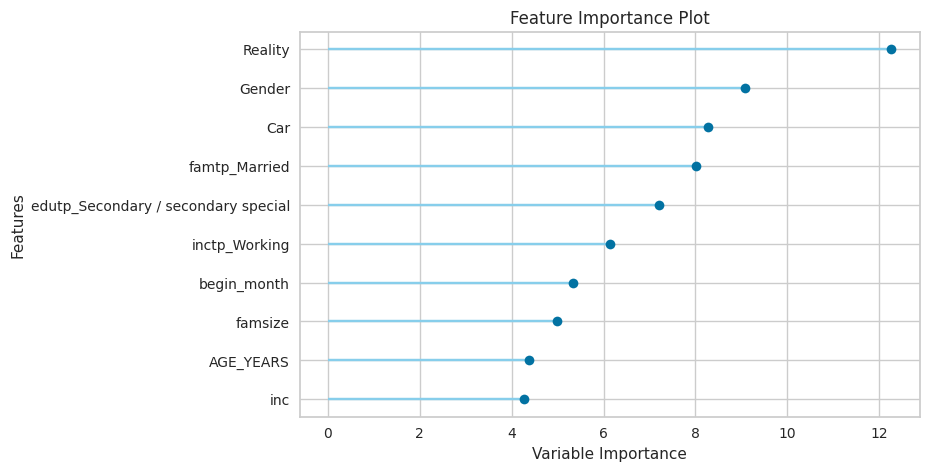

In [0]:
plot_model(catboost_model, plot='feature')

''

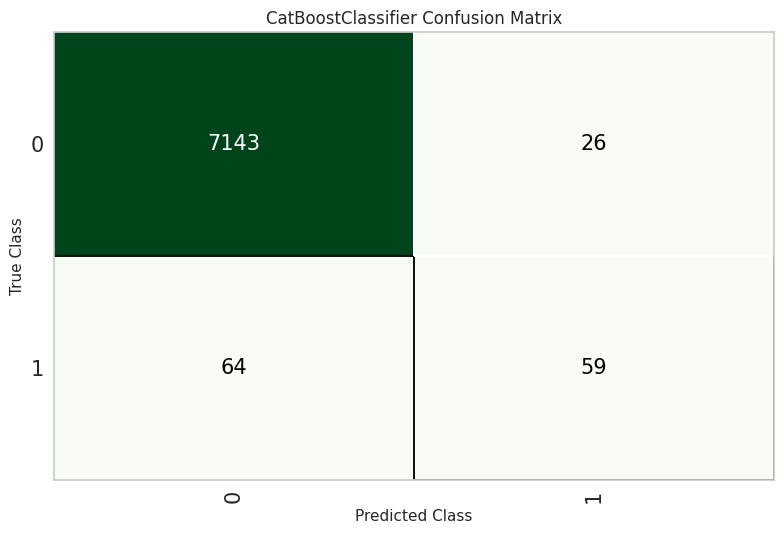

In [0]:
plot_model(catboost_model, plot = 'confusion_matrix')